# Grover Oracle for MAXCut probrem



MAXCut probrem is NP-Hard probrem. But once we define threshold as a condition, MAXCut becomes NP-Complete.

In [1]:
##Mar 1, 2019
#
#code designed by Yasuhiro Okura and Takahiko Satoh and Miguel Ramalho and Lakshmi Prakash


# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx


from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
%matplotlib inline

In [2]:
# from qiskit import IBMQ #TODO
from qiskit import LegacySimulators as Aer


# Import Aer
# from qiskit import BasicAer

# qr = QuantumRegister(5, 'q')
# cr = ClassicalRegister(5, 'c')
# qc = QuantumCircuit(qr, cr)



In [3]:
import random

n = 4 # number of node
edge_direct = random.randint(1, n)
weight = 1.0
print(edge_direct)

4


/Users/Yasuhiro/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


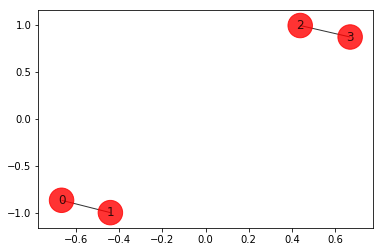

In [4]:
# define edges and weight
# elist = []
# while len(elist)<3: 
# #     print("success1")
#     e_start = random.randint(0, n-1)#it is used to define node connection
#     e_end = random.randint(0, n-1)#it is used to define node connection
# #     print("success2")
    
#     if e_start != e_end:
#         edge = (e_start, e_end, weight)
#         elist.append(edge)
#         print(elist)

# print(elist)
elist=[(2,3,1.0), (0, 1, 1.0)]
G=nx.Graph()
G.add_nodes_from(np.arange(0, n,1))
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

In [5]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        print(temp)
        if temp != 0:
            w[i,j] = temp["weight"] 
print(w)

0
{'weight': 1.0}
0
0
{'weight': 1.0}
0
0
0
0
0
0
{'weight': 1.0}
0
0
{'weight': 1.0}
0
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [6]:
edges = list(G.edges)
print(edges)

while edges:
    i, j = edges.pop()
#     i = int(i)
    print(i, j)

[(0, 1), (2, 3)]
2 3
0 1


In [7]:
## difine circuit

num_x = n # num of node
num_a = 1
num_b = 2
num_c = 1

x = QuantumRegister(num_x, "x")
a = QuantumRegister(num_a, "a")
b = QuantumRegister(num_b, "b")
c = QuantumRegister(num_c, "c")

cr = ClassicalRegister(4, "cr")
qc = QuantumCircuit(x, a ,b, c,  cr)

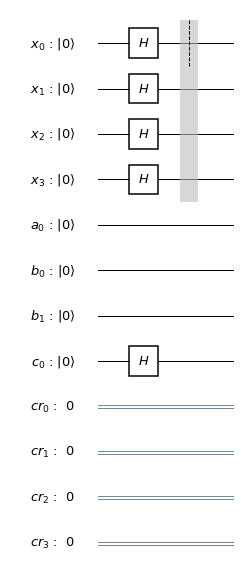

In [8]:
#initialize graph weight
#If Threshold >=2 : SUCCESS!!

qc = QuantumCircuit(x, a ,b, c,  cr)


# qc.x(x[0])
# qc.x(x[1])
# qc.x(x[2])
# qc.x(x[3])

qc.h(x[0])
qc.h(x[1])
qc.h(x[2])
qc.h(x[3])

qc.h(c[0])

qc.barrier()
qc.draw(output = "mpl")



# colors = []
# colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
# nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)


[(0, 1), (2, 3)]
4
0 1
success!
2 3
success!
2 3
success!
0 1
success!


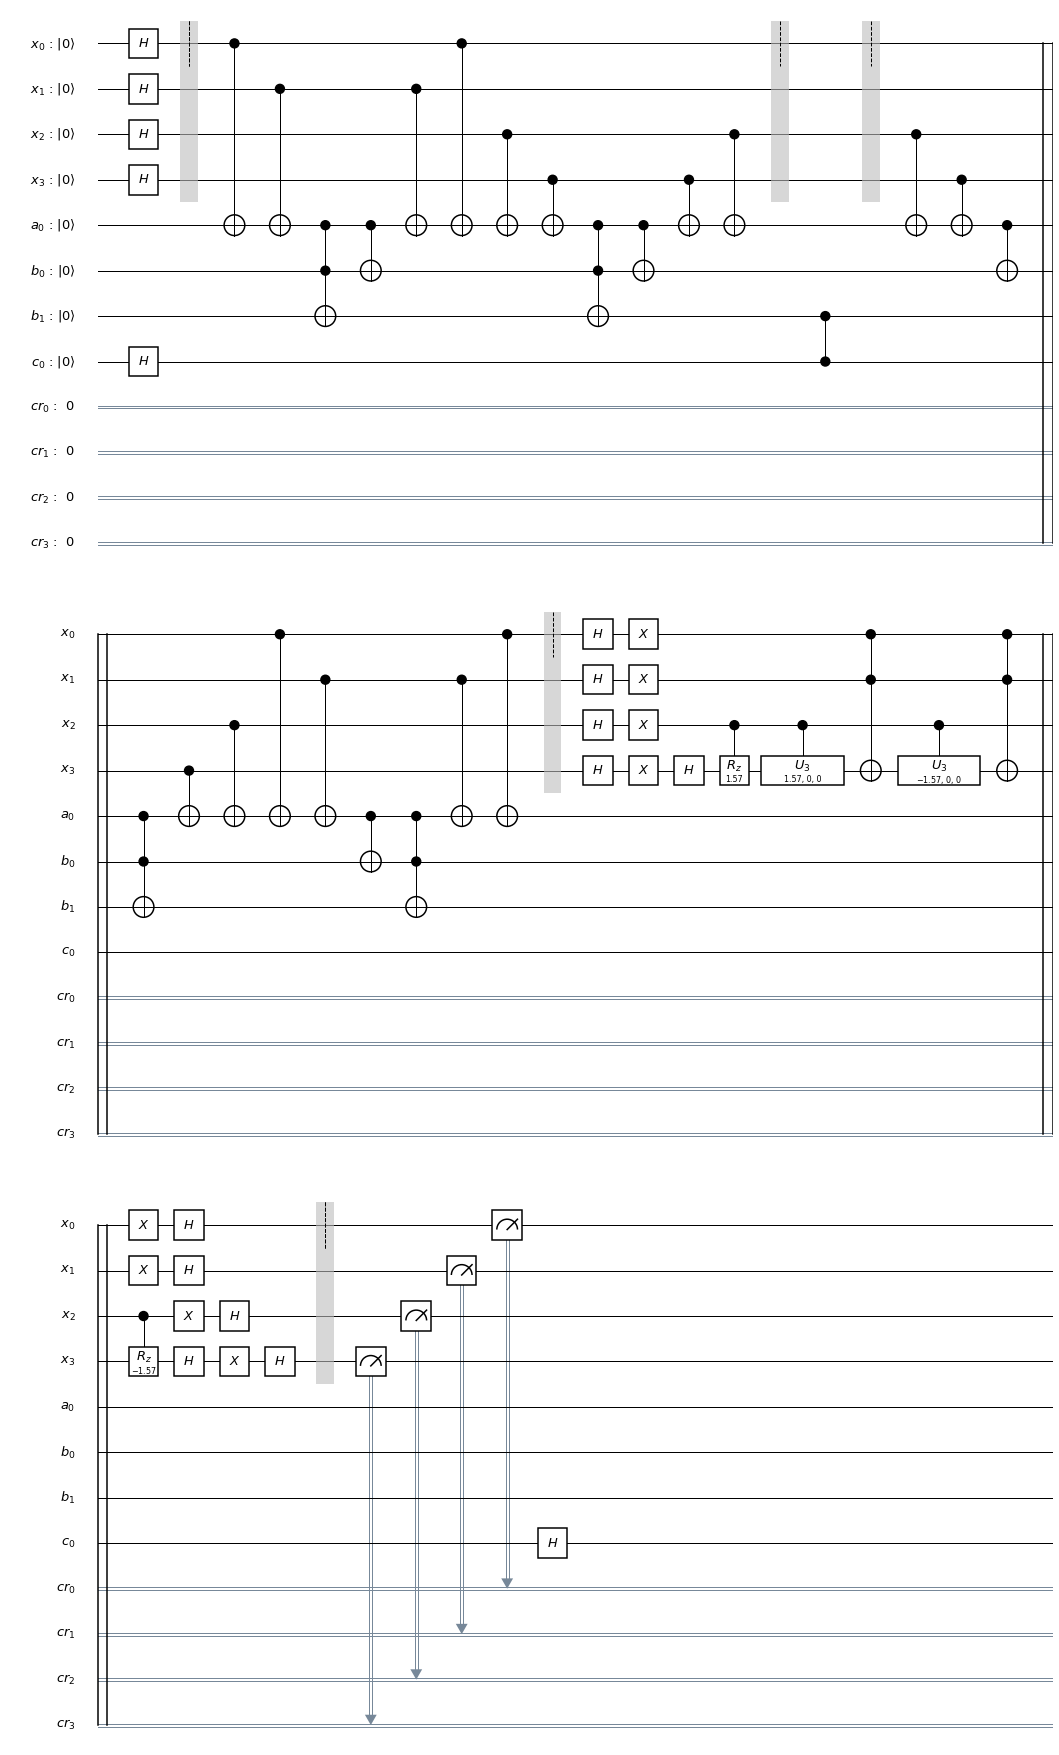

In [9]:
edges = list(G.edges)
print(edges)

## V part(Oracle)
def cut(qc, x, a, b, i, j):
    
    qc.cx(x[i], a)
    qc.cx(x[j], a)

    qc.ccx(a[0], b[0], b[1])
    qc.cx(a[0], b[0])

    qc.cx(x[j], a)
    qc.cx(x[i], a)
    
## V inverse
def icut(qc, x, a, b, i, j):
    
    qc.cx(x[i], a)
    qc.cx(x[j], a)

    qc.cx(a[0], b[0])
    qc.ccx(a[0], b[0], b[1])
    
    qc.cx(x[j], a)
    qc.cx(x[i], a)
    
    
def cnx(qc,*qubits): # C^n-NOT gate
    if len(qubits) > 3:
        last = qubits[-1]
        #A matrix: (made up of a  and Y rotation, lemma4.3)
        qc.crz(np.pi/2, qubits[-2], qubits[-1])
        #cry
        qc.cu3(np.pi/2, 0, 0, qubits[-2],qubits[-1])
        
        #Control not gate
        cnx(qc,*qubits[:-2],qubits[-1])
        
        #B matrix (cry again, but opposite angle)
        qc.cu3(-np.pi/2, 0, 0, qubits[-2], qubits[-1])
        
        #Control
        cnx(qc,*qubits[:-2],qubits[-1])
        
        #C matrix (final rotation)
        qc.crz(-np.pi/2,qubits[-2],qubits[-1])
    elif len(qubits)==3:
        qc.ccx(*qubits)
    elif len(qubits)==2:
        qc.cx(*qubits)

print(num_x)
## D part(Diffusion matrix)
def diff(qc, N): # Diffusion matrix
    for k in range(N):
        qc.h(x[k])
        qc.x(x[k])

    

#     qc.h(x[3])
    qc.h(x[3])
#     cnx(qc, x[0], x[1], x[2], x[3])
    cnx(qc, x[0], x[1], x[2], x[3])
#     qc.h(x[3])
    qc.h(x[3])

    for k in range(N):
        qc.x(x[k])
        qc.h(x[k])

#         qc.h(x[k])
#         qc.x(x[k])


# print(round(np.log(num_x))) # How many times execute V and D
# for l in np.arange(round(np.log(num_x))):



for l in np.arange(1):
    qc.barrier()
    for e in edges:
        i, j = e
        print(i, j)
        cut(qc, x, a, b, int(i), int(j)) # when we should apply int ? Is this right timing?
        print("success!")
    
    qc.barrier()
    qc.cz(b[1], c[0])
    qc.barrier()
    
    for e in edges[::-1]:
        i, j = e
        print(i, j)
        icut(qc, x, a, b, int(i), int(j)) # when we should apply int ? Is this right timing?
        print("success!")
    
    qc.barrier()
    diff(qc, num_x)
    qc.barrier()


qc.barrier()

qc.h(c[0])
## measurement
for l in range(num_x):
    qc.measure(x[l], cr[l])


# qc.measure(a[0], cr[4])
# for m in range(num_a):
#     qc.measure(a[1], cr[num_x+m-1])


qc.draw(output = "mpl")

## Running on QASM simulater

In [10]:
from qiskit.tools.visualization import plot_histogram

In [11]:
print("############ running on QASM simulater ############")

backend = Aer.get_backend('qasm_simulator')
## StateVector Sim
# Run the quantum circuit on a statevector simulator backend
# backend = BasicAer.get_backend('statevector_simulator')
# job_sim = execute(qc, backend=backend)
# result = job_sim.result()
# outputstate = result.get_statevector(qc, decimals=3)

# print(outputstate)

job_sim = execute(qc, backend=backend)
result = job_sim.result()
count = result.get_counts(qc)
print(sorted(count.items(), key = lambda x: x[1],reverse=True)[0])
print(count)

############ running on QASM simulater ############


/Users/Yasuhiro/anaconda3/lib/python3.7/site-packages/qiskit/providers/legacysimulators/legacyprovider.py:41: DeprecationWarning: Simulators in the LegacySimulators provider are deprecated. If you want
 maximum compatibility, you can use those in the Simulators provider. If you want to make the most
 of performance, consider installing the Qiskit Aer element and user the Aer provider.
  warnings.warn(DEPRECATION_MSG, DeprecationWarning)
/Users/Yasuhiro/anaconda3/lib/python3.7/site-packages/qiskit/providers/legacysimulators/legacyprovider.py:37: DeprecationWarning: Simulators in the LegacySimulators provider are deprecated. If you want
 maximum compatibility, you can use those in the Simulators provider. If you want to make the most
 of performance, consider installing the Qiskit Aer element and user the Aer provider.
  warnings.warn(DEPRECATION_MSG, DeprecationWarning)


('0110', 119)
{'1100': 40, '0010': 45, '1000': 44, '1001': 106, '0000': 50, '1010': 104, '0111': 49, '0011': 47, '0100': 62, '1101': 58, '1011': 44, '0001': 52, '1110': 51, '1111': 42, '0110': 119, '0101': 111}


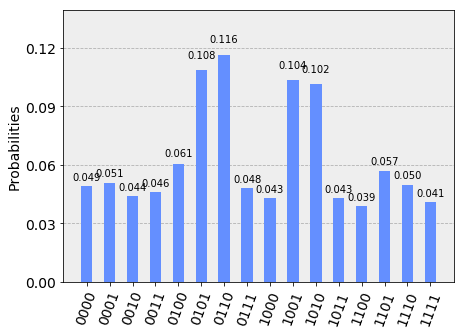

In [12]:
# from qiskit.tools.visualization import plot_state_city
# plot_state_city(outputstate)
plot_histogram(count)

## Runnning on IBMQ

In [13]:
# TODO
print("############ running on IBMQ  ############")

############ running on IBMQ  ############
